# 初期設定

## ライブラリ

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# 主なバリデーション手法

## stratified k-fold
- 層化抽出 | 分類タスクの場合foldごとにクラスの割合を等しくする抽出方法
- テストデータに含まれる各クラスの割合は学習データの割合と同様であろうという仮定

4


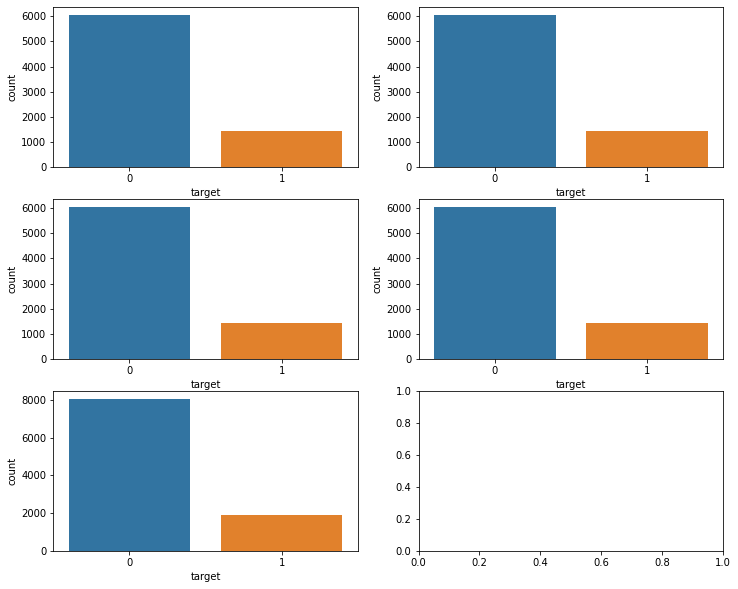

In [5]:
# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）
train = pd.read_csv('../input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('../input/sample-data/test_preprocessed.csv')

# xgboostによる学習・予測を行うクラス
import xgboost as xgb


class Model:

    def __init__(self, params=None):
        self.model = None
        if params is None:
            self.params = {}
        else:
            self.params = params

    def fit(self, tr_x, tr_y, va_x, va_y):
        params = {'objective': 'binary:logistic', 'silent': 1, 'random_state': 71}
        params.update(self.params)
        num_round = 10
        dtrain = xgb.DMatrix(tr_x, label=tr_y)
        dvalid = xgb.DMatrix(va_x, label=va_y)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        self.model = xgb.train(params, dtrain, num_round, evals=watchlist)

    def predict(self, x):
        data = xgb.DMatrix(x)
        pred = self.model.predict(data)
        return pred

# sns.countplot(x='target', data=train)

# -----------------------------------
# Stratified K-Fold
# -----------------------------------
from sklearn.model_selection import StratifiedKFold

# StratifiedKFoldクラスを用いて層化抽出による分割を行う
trains = []
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y), 1):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    trains.append(tr_y)

# 分布を確認
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
a = pd.DataFrame(trains[0])
b = pd.DataFrame(trains[1])
c = pd.DataFrame(trains[2])
d = pd.DataFrame(trains[3])

print(len(trains))
sns.countplot(x='target', data=a, ax=axes[0][0])
sns.countplot(x='target', data=b, ax=axes[0][1])
sns.countplot(x='target', data=c, ax=axes[1][0])
sns.countplot(x='target', data=d, ax=axes[1][1])
sns.countplot(x='target', data=train, ax=axes[2][0])
plt.show()

## group k-fold
- 各顧客に複数の行動履歴があり、それぞれの行動に対して予測を行うタスクの場合
  - 顧客単位でデータが学習とテストで分かれている -> trとvaも同じように顧客単位で分けなければ過大評価してしまう


In [6]:
# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）
train = pd.read_csv('../input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('../input/sample-data/test_preprocessed.csv')

# -----------------------------------
# GroupKFold
# -----------------------------------
# 4件ずつ同じユーザーがいるデータであったとする
# // 除算した際の整数部のみ
train_x['user_id'] = np.arange(0, len(train_x)) // 4
# -----------------------------------

from sklearn.model_selection import KFold, GroupKFold

# user_id列の顧客IDを単位として分割することにする
user_id = train_x['user_id']
unique_user_ids = user_id.unique()

# KFoldクラスを用いて、顧客ID単位で分割する
scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_group_idx, va_group_idx in kf.split(unique_user_ids):
    # 顧客IDをtrain/valid（学習に使うデータ、バリデーションデータ）に分割する
    # indexに基づいたunique_user_idsをtrとvaで分割
    # tr_groups, va_groupsには[True, False]のSeriesが入る
    tr_groups, va_groups = unique_user_ids[tr_group_idx], unique_user_ids[va_group_idx]

    # 各レコードの顧客IDがtrain/validのどちらに属しているかによって分割する
    is_tr = user_id.isin(tr_groups)
    is_va = user_id.isin(va_groups)
    tr_x, va_x = train_x[is_tr], train_x[is_va]
    tr_y, va_y = train_y[is_tr], train_y[is_va]

In [ ]:
# （参考）GroupKFoldクラスではシャッフルと乱数シードの指定ができないため使いづらい
from sklearn.model_selection import GroupKFold

kf = GroupKFold(n_splits=4)
for tr_idx, va_idx in kf.split(train_x, train_y, user_id):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# 時系列データのバリデーション手法
- 学習データにテストデータと同じ期間のデータが含まれていないケース

## 時系列データのhold-out法
- 時系列を考慮したhold-out
- テストデータに最も近い期間をバリデーションデータとする（時間的に近いほどデータの傾向が似ているという仮定）
    - 1年ごとの周期性が強いデータの場合は直近よりもテストデータの１年前の期間をバリデーションデータとした方が良い可能性がある
- **最終的にはバリデーションで求めた最適な特徴量やパラメータをそのまま使ってバリデーションデータも含めて再学習する方が良い**
    - 再学習モデルは評価できないが特徴量、パラメータはそのままで学習データの期間が少し変わっただけなので大きな問題はないという考え方
- 基本的にデータを有効に扱えていない
    - バリデーションデータがある期間に限定されている
    - バリデーションデータのレコードが足りないために結果が安定しないことがある

In [7]:
# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd

# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）

train = pd.read_csv('../input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('../input/sample-data/test_preprocessed.csv')

# 時系列データであり、時間に沿って変数periodを設定したとする
## 時系列でデータを並ばせた前提での処理である
train_x['period1'] = np.arange(0, len(train_x))
# 10000 // 4 = 2500
train_x['period2'] = (len(train_x) // 4)
train_x['period'] = train_x['period1'] // train_x['period2']
# このプログラムではclipしなくても良い
# train_x['period'] = np.clip(train_x['period'], 0, 3)
test_x['period'] = 4

# -----------------------------------
# 時系列データのhold-out法
# -----------------------------------
# 変数periodを基準に分割することにする（0から3までが学習データ、4がテストデータとする）
# ここでは、学習データのうち、変数periodが3のデータをバリデーションデータとし、0から2までのデータを学習に用いる
is_tr = train_x['period'] < 3
is_va = train_x['period'] == 3
tr_x, va_x = train_x[is_tr], train_x[is_va]
tr_y, va_y = train_y[is_tr], train_y[is_va]

## 時系列データのクロスバリデーション
- 時系列に沿って分割した後、時間的な関係性を保ちながら評価を繰り返す方法
- 学習データの最初からともできるし（左図）、バリデーションデータの直前の１年間などのように揃えることもできる（右図）
    - この場合、区切った期間よりも過去のデータが使えなくなる

 ![時系列クロスバリデーション](/Users/nozawayuta/GitHub/kagglebook/misc/IMG_2BCB5C2E27C9-1.jpeg "時系列クロスバリデーション")

In [8]:
# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd

# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）

train = pd.read_csv('../input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('../input/sample-data/test_preprocessed.csv')

# 時系列データであり、時間に沿って変数periodを設定したとする
train_x['period1'] = np.arange(0, len(train_x))
# 10000 // 4 = 2500
train_x['period2'] = (len(train_x) // 4)
train_x['period'] = train_x['period1'] // train_x['period2']
# このプログラムではclipしなくても良い
# train_x['period'] = np.clip(train_x['period'], 0, 3)
test_x['period'] = 4

# -----------------------------------
# 時系列データのクロスバリデーション（時系列に沿って行う方法）
# -----------------------------------
# 変数periodを基準に分割することにする（0から3までが学習データ、4がテストデータとする）
# 変数periodが1, 2, 3のデータをそれぞれバリデーションデータとし、それ以前のデータを学習に使う

va_period_list = [1, 2, 3]
for va_period in va_period_list:
    is_tr = train_x['period'] < va_period
    is_va = train_x['period'] == va_period
    tr_x, va_x = train_x[is_tr], train_x[is_va]
    tr_y, va_y = train_y[is_tr], train_y[is_va]
    # foldを重ねるごとにtr_xが増えていくことを確認
    print(tr_x.shape[0])
    # print(va_x.shape[0])

2500
2500
5000
2500
7500
2500


In [ ]:
# （参考）TimeSeriesSplitの場合、データの並び順を整理してからしか使えないため使いづらい
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4)
for tr_idx, va_idx in tss.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

## 時系列データのクロスバリデーション（単純に時間で分割する方法）
- レコード間の時間的な前後関係はあまり気にしない場合に使用 -> **どんな時？**
 ![時系列クロスバリデーション_単純分割](/Users/nozawayuta/GitHub/kagglebook/misc/IMG_53F5D82897B1-1.jpeg "時系列クロスバリデーション_単純分割")

In [17]:
# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd

# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）

train = pd.read_csv('../input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('../input/sample-data/test_preprocessed.csv')

# 時系列データであり、時間に沿って変数periodを設定したとする
train_x['period1'] = np.arange(0, len(train_x))
# 10000 // 4 = 2500
train_x['period2'] = (len(train_x) // 4)
train_x['period'] = train_x['period1'] // train_x['period2']
# このプログラムではclipしなくても良い
# train_x['period'] = np.clip(train_x['period'], 0, 3)
test_x['period'] = 4

# -----------------------------------
# 時系列データのクロスバリデーション（単純に時間で分割する方法）
# -----------------------------------
# 変数periodを基準に分割することにする（0から3までが学習データ、4がテストデータとする）
# 変数periodが0, 1, 2, 3のデータをそれぞれバリデーションデータとし、それ以外の学習データを学習に使う

va_period_list = [0, 1, 2, 3]
for va_period in va_period_list:
    is_tr = train_x['period'] != va_period
    is_va = train_x['period'] == va_period
    tr_x, va_x = train_x[is_tr], train_x[is_va]
    tr_y, va_y = train_y[is_tr], train_y[is_va]
    # foldを重ねるごとにtr_xが期待通り変化しているかを確認
    print(tr_x['period'].unique())

[1 2 3]
[0 2 3]
[0 1 3]
[0 1 2]
